In [75]:
import pandas as pd
import numpy as np
import glob
import os

# Time encoding function
def encode_time(value, max_value):
    value_sin = np.sin(2 * np.pi * value / max_value)
    value_cos = np.cos(2 * np.pi * value / max_value)
    return value_sin, value_cos

# Function to process marginal data
def process_marginal(file_path):
    try:
        data = pd.read_csv(file_path)
        data = data.rename(columns={'DA ES': 'DA'})
        data = data[['Year', 'Month', 'Day', 'Hour', 'DA']].dropna()
        return data
    except Exception as e:
        print(f"Error processing marginal file {file_path}: {e}")
        return None

# Function to process intra-day data
def process_intra_day(file_path):
    try:
        data = pd.read_csv(file_path)
        data = data.rename(columns={'AvgES': 'ID'})
        data = data[['Year', 'Month', 'Day', 'Hour', 'ID']].dropna()
        return data
    except Exception as e:
        print(f"Error processing intra-day file {file_path}: {e}")
        return None


# Function to process gas price data
def process_gas(file_paths):

    all_gas_data = []
    for file_path in file_paths:
        try:
            # Load the Excel file
            gas_data = pd.read_excel(file_path, sheet_name="Regulated gas")
            
            # Use column positions to rename, assuming consistent format
            gas_data = gas_data.rename(columns={
                gas_data.columns[0]: 'Trading_Day',
                gas_data.columns[4]: 'Price_EUR_MWh',
                gas_data.columns[5]: 'Volume_MWh'
            })
            
            # Convert 'Trading_Day' to datetime
            gas_data['Trading_Day'] = pd.to_datetime(gas_data['Trading_Day'], errors='coerce')
            
            # Drop rows with invalid dates
            gas_data = gas_data.dropna(subset=['Trading_Day'])
            
            # Extract Year, Month, and Day for merging
            gas_data['Year'] = gas_data['Trading_Day'].dt.year
            gas_data['Month'] = gas_data['Trading_Day'].dt.month
            gas_data['Day'] = gas_data['Trading_Day'].dt.day
            
            # Sort the data to ensure proper forward-fill order
            gas_data = gas_data.sort_values(by=['Year', 'Month', 'Day'])
            
            # Fill missing prices and volumes using forward-fill
            gas_data['Price_EUR_MWh'] = gas_data['Price_EUR_MWh'].ffill()
            gas_data['Volume_MWh'] = gas_data['Volume_MWh'].ffill()
            
            # Keep only relevant columns
            gas_data = gas_data[['Year', 'Month', 'Day', 'Price_EUR_MWh', 'Volume_MWh']]
            
            # Append to the list
            all_gas_data.append(gas_data)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
    # Combine all gas data
    combined_gas_data = pd.concat(all_gas_data, ignore_index=True)
    
    # Remove duplicates
    combined_gas_data = combined_gas_data.drop_duplicates(subset=['Year', 'Month', 'Day'])
    
    print("Gas data processed successfully.")
    return combined_gas_data


def process_misc(file_paths):
    print("Processing misc files...")
    all_misc_data = []
    for file_path in file_paths:
        try:
            misc_data = pd.read_csv(file_path, sep=';')
            misc_data['Row Labels'] = pd.to_datetime(misc_data['Row Labels'], errors='coerce', utc=True)
            misc_data = misc_data.dropna(subset=['Row Labels'])  # Drop rows with invalid dates
            misc_data['Year'] = misc_data['Row Labels'].dt.year
            misc_data['Month'] = misc_data['Row Labels'].dt.month
            misc_data['Day'] = misc_data['Row Labels'].dt.day
            misc_data['Hour'] = misc_data['Row Labels'].dt.hour
            misc_data = misc_data.rename(columns={
                'Real Demand': 'Demand',
                'Wind generation': 'Wind_Generation',
                'PV generation': 'PV_Generation'
            })
            misc_data = misc_data[['Year', 'Month', 'Day', 'Hour', 'Demand', 'Wind_Generation', 'PV_Generation']]
            all_misc_data.append(misc_data)
        except Exception as e:
            print(f"Error processing misc file {file_path}: {e}")
    combined_misc_data = pd.concat(all_misc_data, ignore_index=True)
    print("Misc data processed successfully.")
    return combined_misc_data


def process_weather(file_paths):
    all_weather_data = []
    for file_path in file_paths:
        try:
            weather_data = pd.read_csv(file_path)
            weather_data['valid_time'] = pd.to_datetime(weather_data['valid_time'])
            weather_data['Year'] = weather_data['valid_time'].dt.year
            weather_data['Month'] = weather_data['valid_time'].dt.month
            weather_data['Day'] = weather_data['valid_time'].dt.day
            weather_data['Hour'] = weather_data['valid_time'].dt.hour
            weather_data = weather_data.drop(columns=[col for col in weather_data.columns if '_latitude' in col or '_longitude' in col])
            all_weather_data.append(weather_data)
        except Exception as e:
            print(f"Error processing weather file {file_path}: {e}")
    combined_weather_data = pd.concat(all_weather_data, ignore_index=True).drop_duplicates()
    print("Weather data processed successfully.")
    return combined_weather_data

def process_demand(file_path):
    try:
        demand_data = pd.read_csv(file_path, sep=',', usecols=['value', 'datetime'])
        demand_data['datetime'] = pd.to_datetime(demand_data['datetime'], utc=True)
        demand_data['Year'] = demand_data['datetime'].dt.year
        demand_data['Month'] = demand_data['datetime'].dt.month
        demand_data['Day'] = demand_data['datetime'].dt.day
        demand_data['Hour'] = demand_data['datetime'].dt.hour
        return demand_data.rename(columns={'value': 'Predicted_Demand'})[['Year', 'Month', 'Day', 'Hour', 'Predicted_Demand']]
    except Exception as e:
        print(f"Error processing demand file: {e}")
        return None

def process_wind_photovoltaic(file_path):
    try: 
        print("Processing wind and photovoltaic data...")
        wind_prediction = pd.read_csv(file_path, sep=';', usecols=['value', 'datetime'])
        wind_prediction['datetime'] = pd.to_datetime(wind_prediction['datetime'], utc=True)
        wind_prediction['Year'] = wind_prediction['datetime'].dt.year
        wind_prediction['Month'] = wind_prediction['datetime'].dt.month
        wind_prediction['Day'] = wind_prediction['datetime'].dt.day
        wind_prediction['Hour'] = wind_prediction['datetime'].dt.hour
        wind_prediction = wind_prediction.rename(columns={'value': 'Wind_Prediction'})[['Year', 'Month', 'Day', 'Hour', 'Wind_Prediction']]
    except Exception as e:
        print(f"Error processing wind prediction file: {e}")
        wind_prediction = None

    return wind_prediction

def process_demand_forecast(file_path):
    try:
        print("Processing demand forecast data...")
        demand_data = pd.read_csv(file_path, sep=';', usecols=['value', 'datetime'])
        demand_data['datetime'] = pd.to_datetime(demand_data['datetime'], utc=True)
        demand_data['Year'] = demand_data['datetime'].dt.year
        demand_data['Month'] = demand_data['datetime'].dt.month
        demand_data['Day'] = demand_data['datetime'].dt.day
        demand_data['Hour'] = demand_data['datetime'].dt.hour
        return demand_data.rename(columns={'value': 'Predicted_Demand_Renewables'})[['Year', 'Month', 'Day', 'Hour', 'Predicted_Demand_Renewables']]
    except Exception as e:
        print(f"Error processing demand file: {e}")
        return None

In [77]:
import pandas as pd
import numpy as np
import glob
import os

# Define directories
data_dir = '../raw_data/'
output_dir = '../formatted_data/'

# Discover files
marginal_files = glob.glob(os.path.join(data_dir, 'data_electric/data_da*.csv'))
intra_day_files = glob.glob(os.path.join(data_dir, 'data_electric/data_id*.csv'))
gas_files = glob.glob(os.path.join(data_dir, 'data_gas/original_gas/*.xlsx'))
misc_files = glob.glob(os.path.join(data_dir, 'data_electric/misc*.csv'))
weather_files = glob.glob(os.path.join(data_dir, 'data_weather/*.csv'))
demand_file = os.path.join(data_dir, 'data_electric/data_demand.csv')
wind_file = os.path.join(data_dir, 'data_electric/data_wind_photovoltaic_forecast.csv')
demand_forecast_file = os.path.join(data_dir, 'data_electric/data_demand_daily_forecast.csv')

print(f"Found {len(marginal_files)} marginal files")
print(f"Found {len(intra_day_files)} intra-day files")
print(f"Found {len(gas_files)} gas price files")
print(f"Found {len(misc_files)} misc files")
print(f"Found {len(weather_files)} weather files")
print(f"Found demand file: {demand_file}")
print(f"Found wind file: {wind_file}")
print(f"Found demand forecast file: {demand_forecast_file}")

# Time encoding function
def encode_time(value, max_value):
    value_sin = np.sin(2 * np.pi * value / max_value)
    value_cos = np.cos(2 * np.pi * value / max_value)
    return value_sin, value_cos

# Process marginal and intra-day data
marginal_data = pd.concat(
    [df for file in marginal_files if (df := process_marginal(file)) is not None and not df.empty],
    ignore_index=True
)
intra_day_data = pd.concat(
    [df for file in intra_day_files if (df := process_intra_day(file)) is not None and not df.empty],
    ignore_index=True
)

gas_data = process_gas(gas_files)
misc_data = process_misc(misc_files)
weather_data = process_weather(weather_files)
demand_data = process_demand(demand_file)
wind_photovoltaic_data = process_wind_photovoltaic(wind_file)
demand_forecast_data = process_demand_forecast(demand_forecast_file)

# Merge datasets
final_data = pd.merge(marginal_data, intra_day_data, on=['Year', 'Month', 'Day', 'Hour'], how='inner')
final_data = pd.merge(final_data, misc_data, on=['Year', 'Month', 'Day', 'Hour'], how='left')
final_data = pd.merge(final_data, demand_data, on=['Year', 'Month', 'Day', 'Hour'], how='left')
final_data = pd.merge(final_data, gas_data, on=['Year', 'Month', 'Day'], how='left')
final_data = pd.merge(final_data, weather_data, on=['Year', 'Month', 'Day', 'Hour'], how='left')
final_data = pd.merge(final_data, wind_photovoltaic_data, on=['Year', 'Month', 'Day', 'Hour'], how='left')
final_data = pd.merge(final_data, demand_forecast_data, on=['Year', 'Month', 'Day', 'Hour'], how='left')


# Apply forward fill
final_data = final_data.sort_values(by=['Year', 'Month', 'Day', 'Hour'])
# Forward fill for missing values and backfill for the first row
final_data = final_data.ffill().bfill()

# Add encoded time columns
final_data['Hour_Sin'], final_data['Hour_Cos'] = zip(*final_data['Hour'].apply(lambda x: encode_time(x, 24)))
final_data['Day_Sin'], final_data['Day_Cos'] = zip(*final_data['Day'].apply(lambda x: encode_time(x, 31)))
final_data['Month_Sin'], final_data['Month_Cos'] = zip(*final_data['Month'].apply(lambda x: encode_time(x, 12)))

# Add scaled Year and price difference
final_data['Year_Scaled'] = (final_data['Year'] - 2018) * 0.1 + 0.1
final_data['Diff'] = final_data['DA'] - final_data['ID']

# Save the processed data
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'formatted_data.csv')
final_data.to_csv(output_file, index=False)
print(f"Processed data saved to {output_file}")

# Validation
missing_values = final_data.isnull().sum()
print("Missing values:")
print(missing_values)

duplicate_dates = final_data.duplicated(subset=['Year', 'Month', 'Day', 'Hour'])
print("Number of duplicate dates:", duplicate_dates.sum())


Found 2 marginal files
Found 2 intra-day files
Found 7 gas price files
Found 1 misc files
Found 2 weather files
Found demand file: ../raw_data/data_electric/data_demand.csv
Found wind file: ../raw_data/data_electric/data_wind_photovoltaic_forecast.csv
Found demand forecast file: ../raw_data/data_electric/data_demand_daily_forecast.csv
Gas data processed successfully.
Processing misc files...
Misc data processed successfully.
Weather data processed successfully.
Processing wind and photovoltaic data...
Processing demand forecast data...
Processed data saved to ../formatted_data/formatted_data.csv
Missing values:
Year           0
Month          0
Day            0
Hour           0
DA             0
              ..
Day_Cos        0
Month_Sin      0
Month_Cos      0
Year_Scaled    0
Diff           0
Length: 89, dtype: int64
Number of duplicate dates: 8


In [78]:
import pandas as pd
import numpy as np
import os

# File paths
formatted_data_path = '../formatted_data/formatted_data.csv'
output_file_with_prediction = '../formatted_data/formatted_data_withWeatherPrediction.csv'

# Add weather predictions

def add_weather_predictions_to_data_simple(formatted_data, noise_std=0.1):
    """
    Add weather predictions by shifting weather data by one row and adding noise.
    """
    weather_columns = [col for col in formatted_data.columns if '_temperature' in col or '_wind_' in col or '_precipitation' in col]

    # Create a copy of the weather data
    weather_predictions = formatted_data[weather_columns].shift(-1)

    # Add Gaussian noise to weather columns
    for col in weather_columns:
        noise = np.random.normal(loc=0, scale=noise_std, size=len(weather_predictions))
        weather_predictions[col] += noise

    # Rename columns to indicate predictions
    weather_predictions.rename(columns={col: f"{col}_Predicted" for col in weather_columns}, inplace=True)

    # Concatenate the predictions with the original data
    formatted_data_with_predictions = pd.concat([formatted_data, weather_predictions], axis=1)

    return formatted_data_with_predictions


# File paths
formatted_data_path = '../formatted_data/formatted_data.csv'
output_file_with_prediction = '../formatted_data/formatted_data_withWeatherPrediction.csv'

# Load formatted data
formatted_data = pd.read_csv(formatted_data_path)

# Add weather predictions
formatted_data_with_predictions = add_weather_predictions_to_data_simple(formatted_data, noise_std=0.1)

# Save the processed data with weather predictions
formatted_data_with_predictions.to_csv(output_file_with_prediction, index=False)
print(f"Processed data with weather predictions saved to {output_file_with_prediction}")



Processed data with weather predictions saved to ../formatted_data/formatted_data_withWeatherPrediction.csv


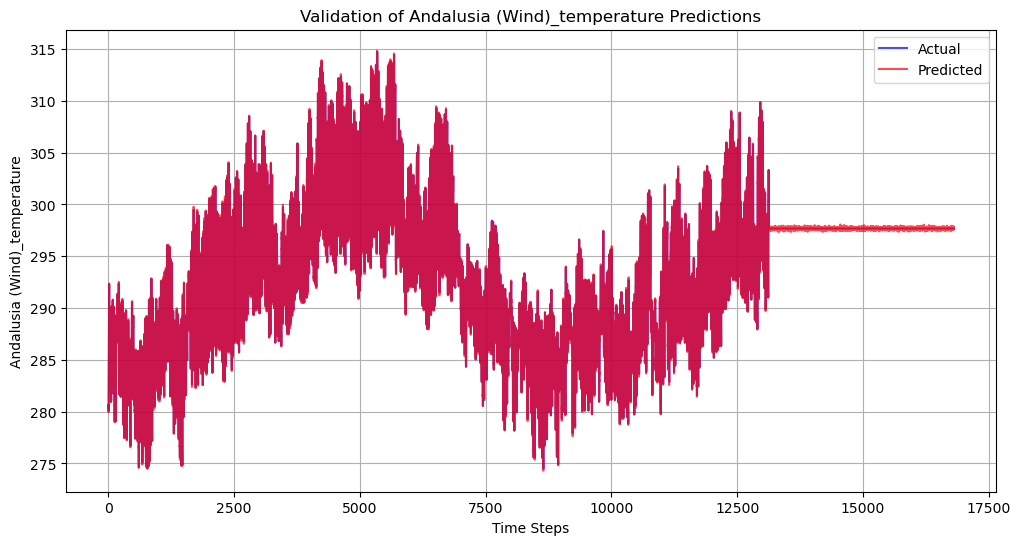

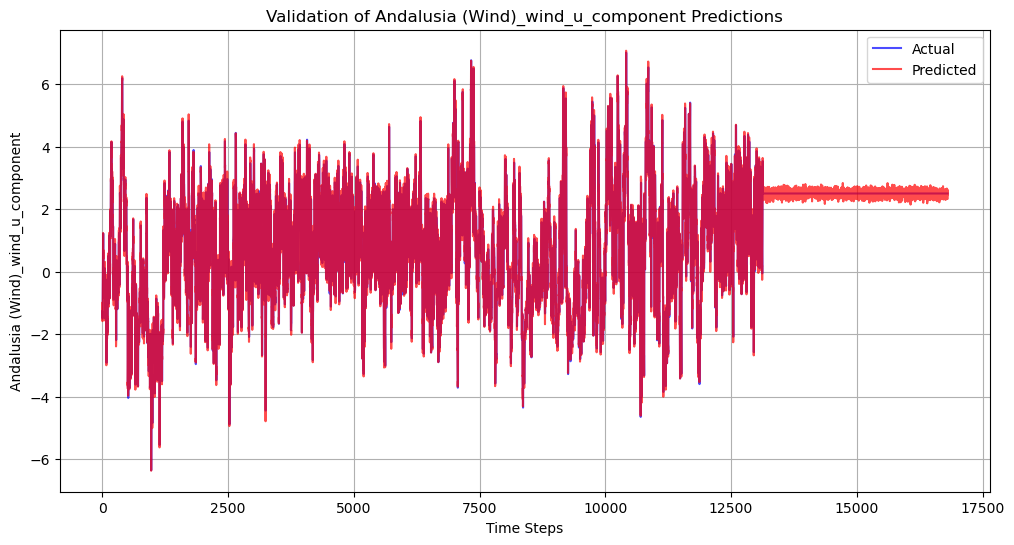

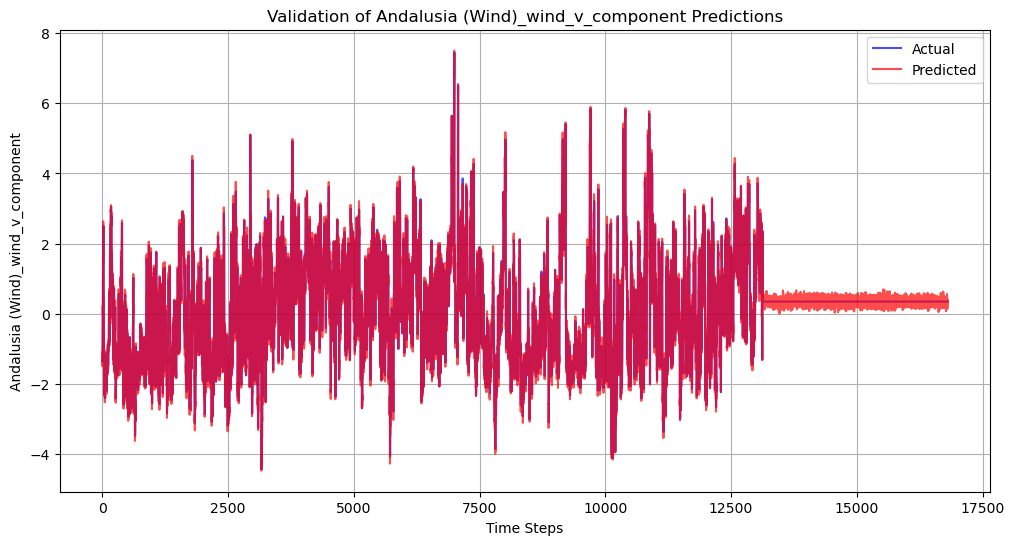

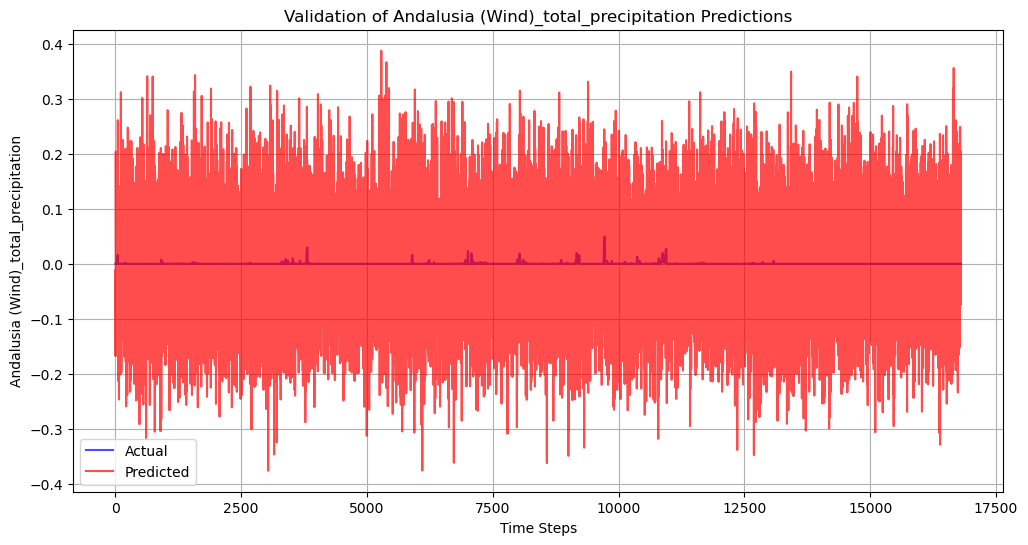

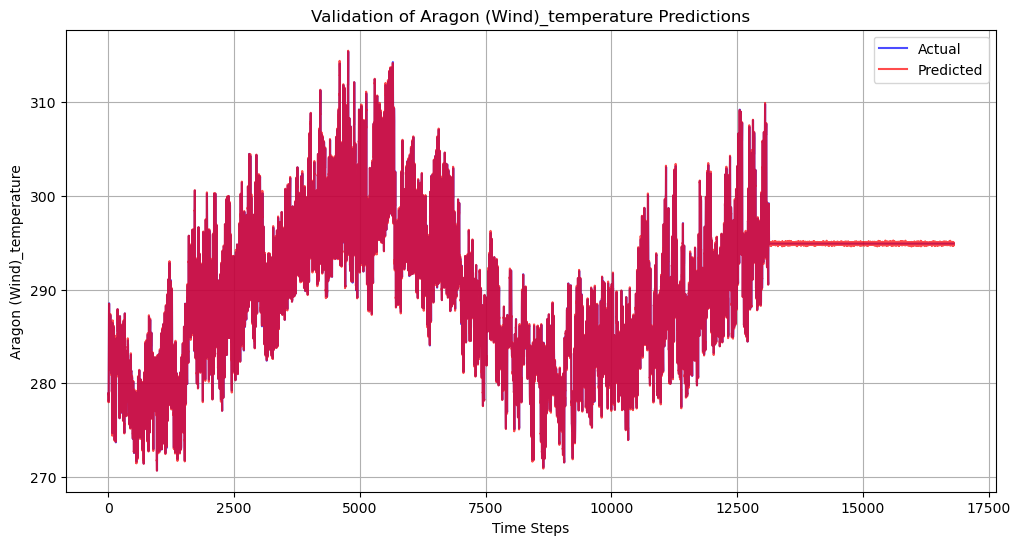

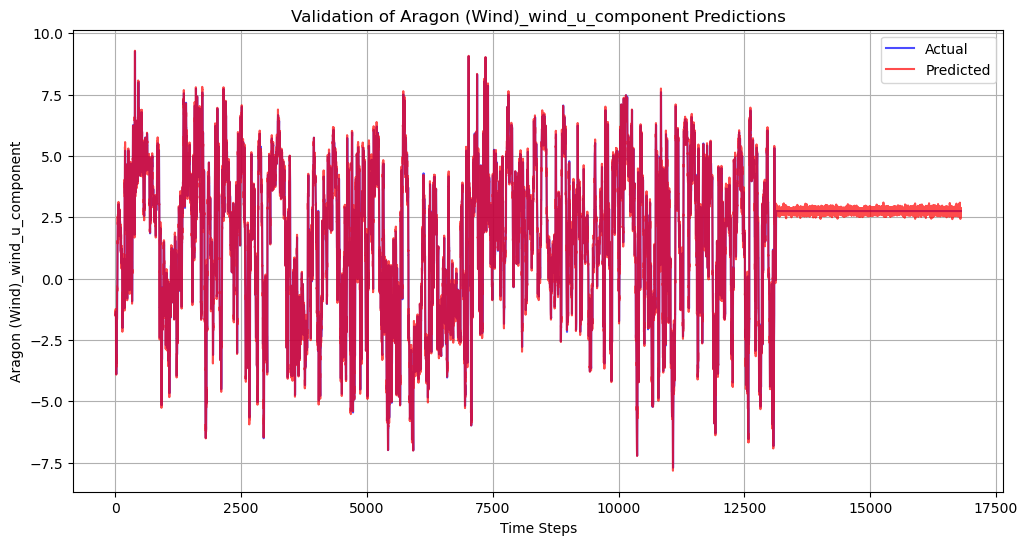

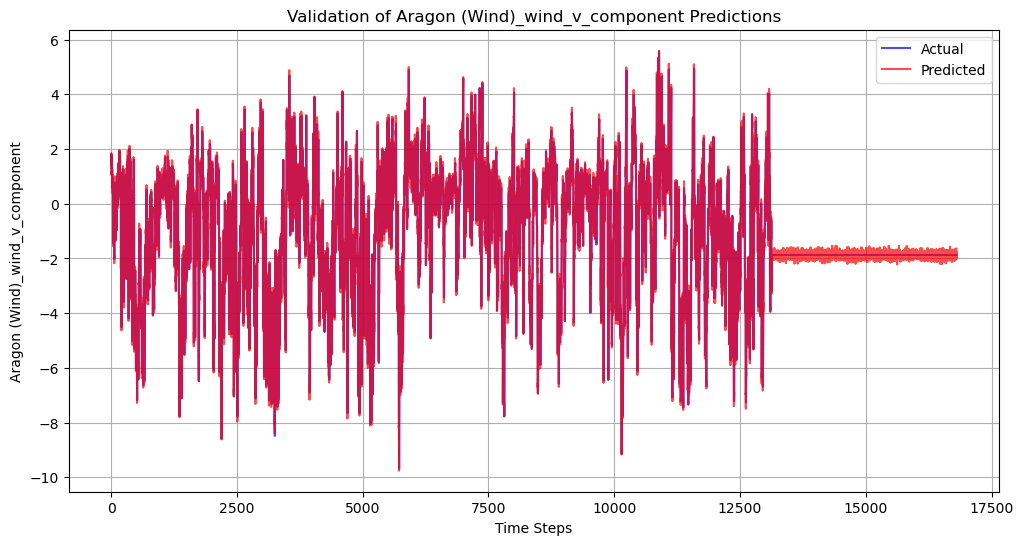

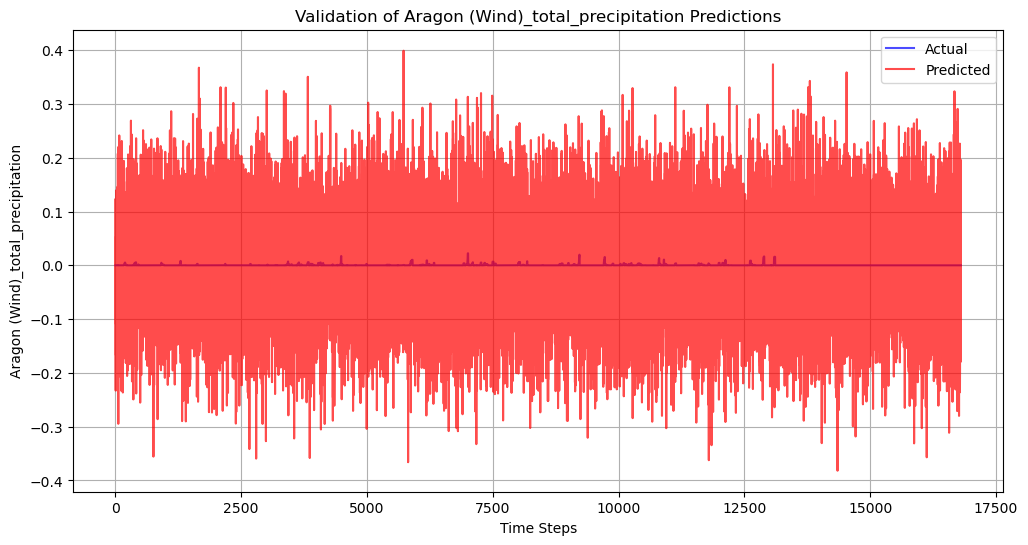

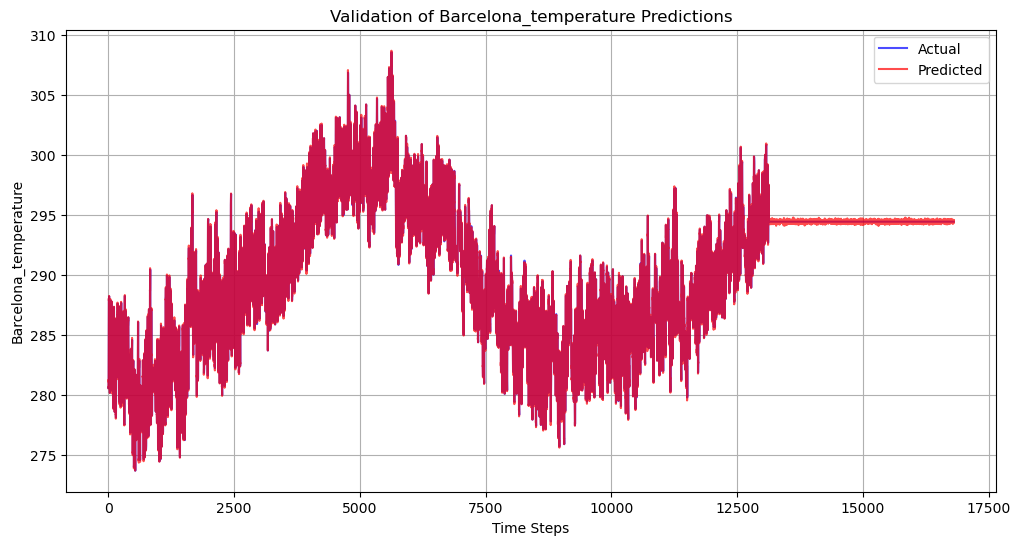

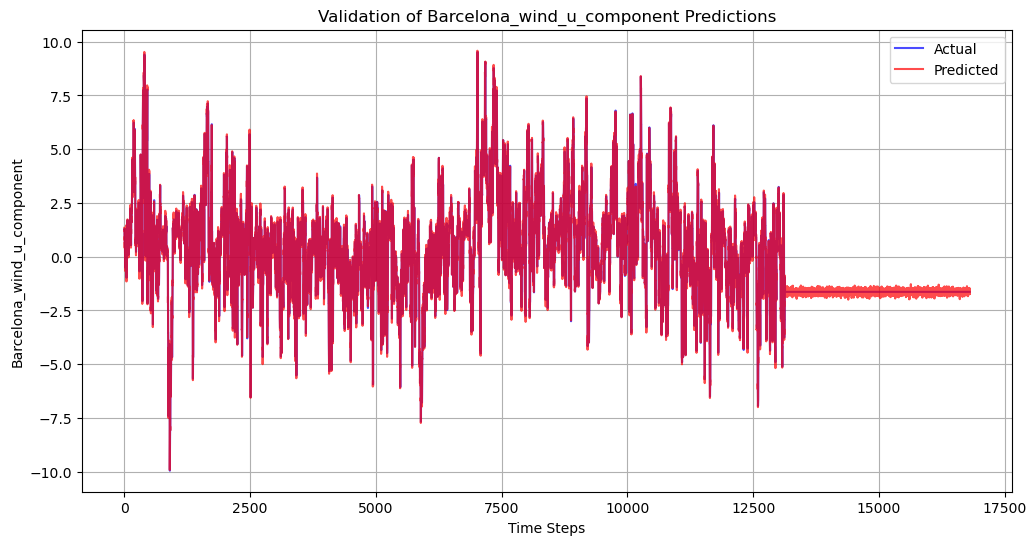

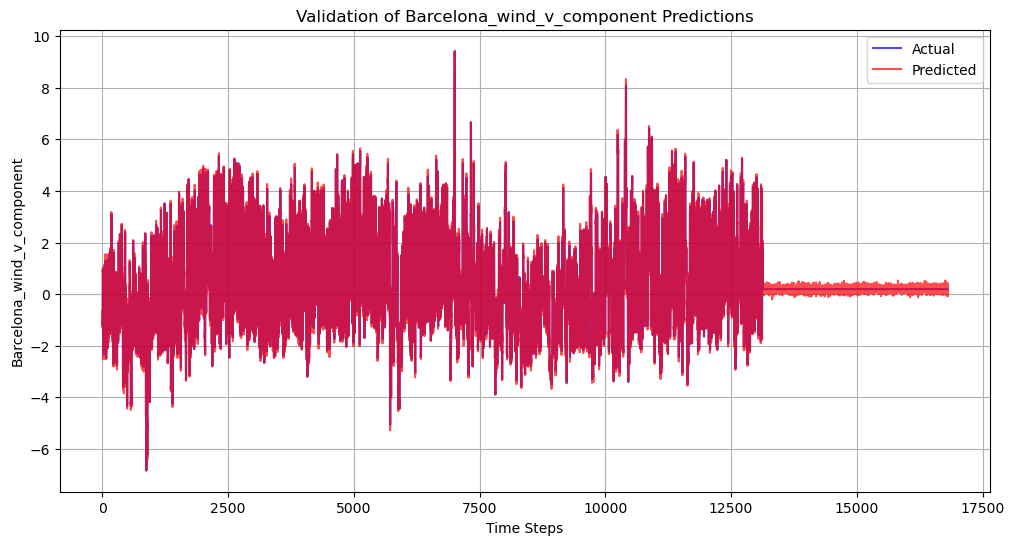

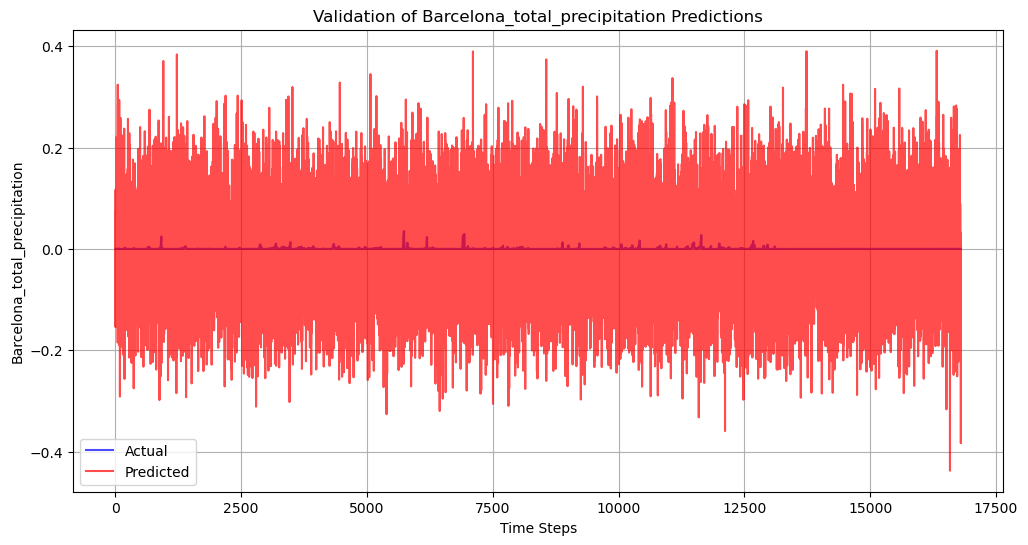

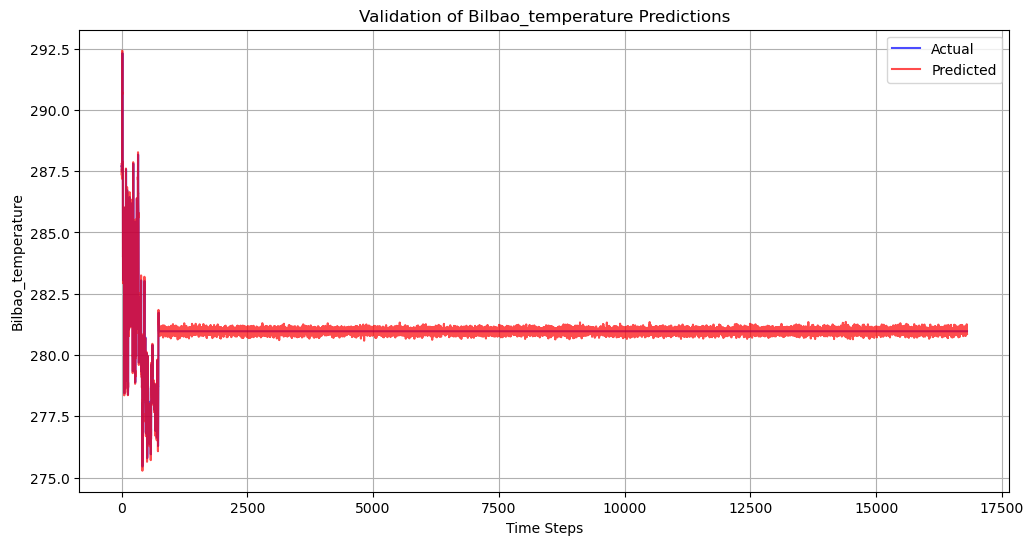

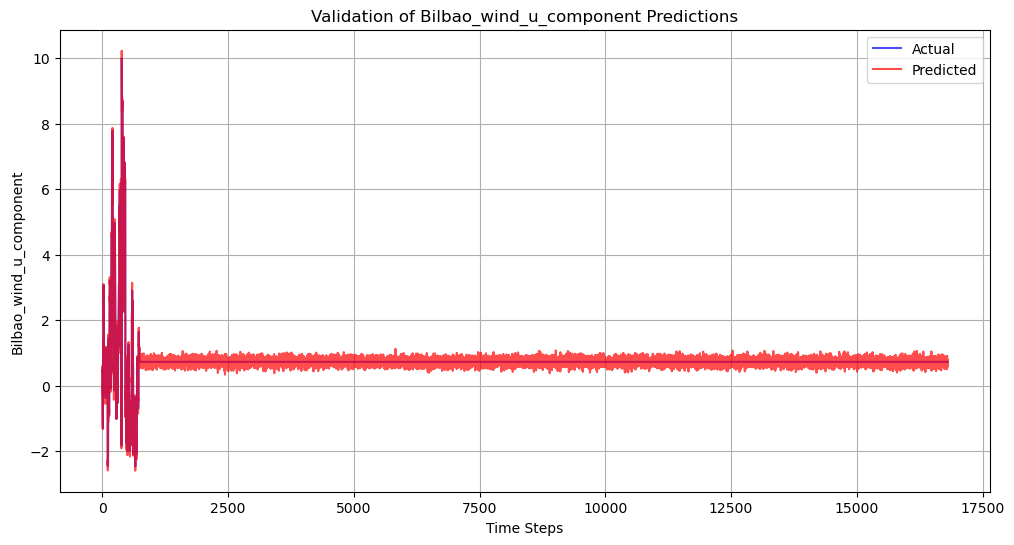

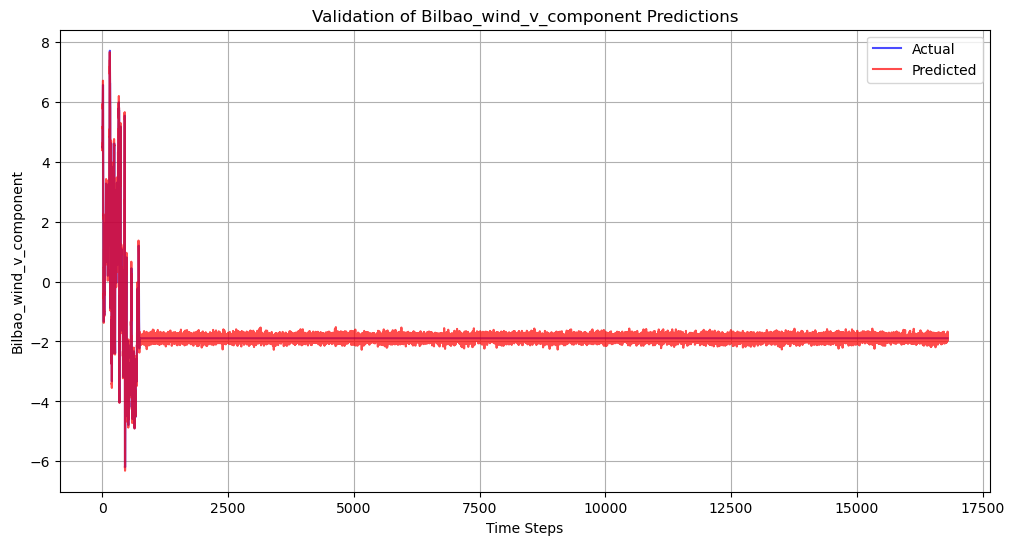

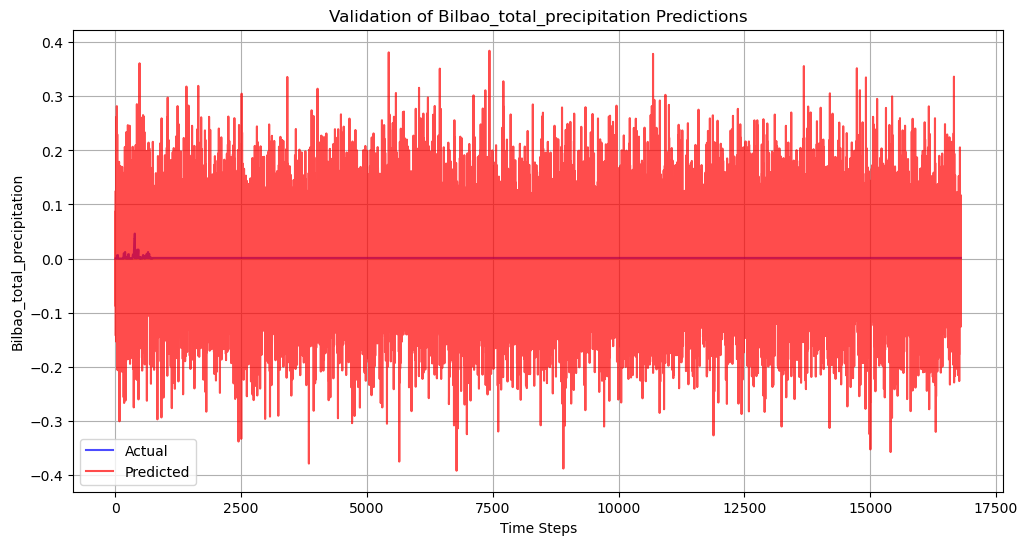

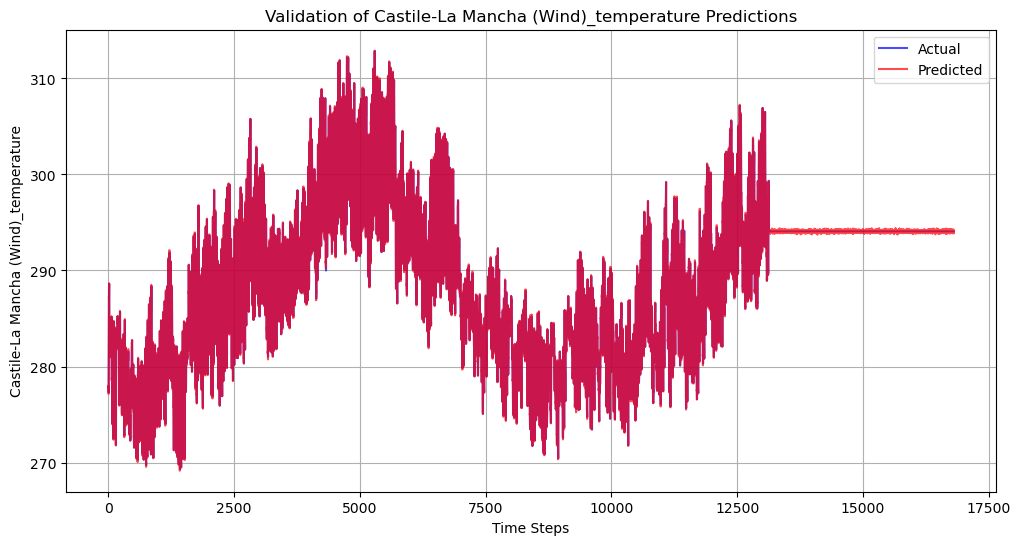

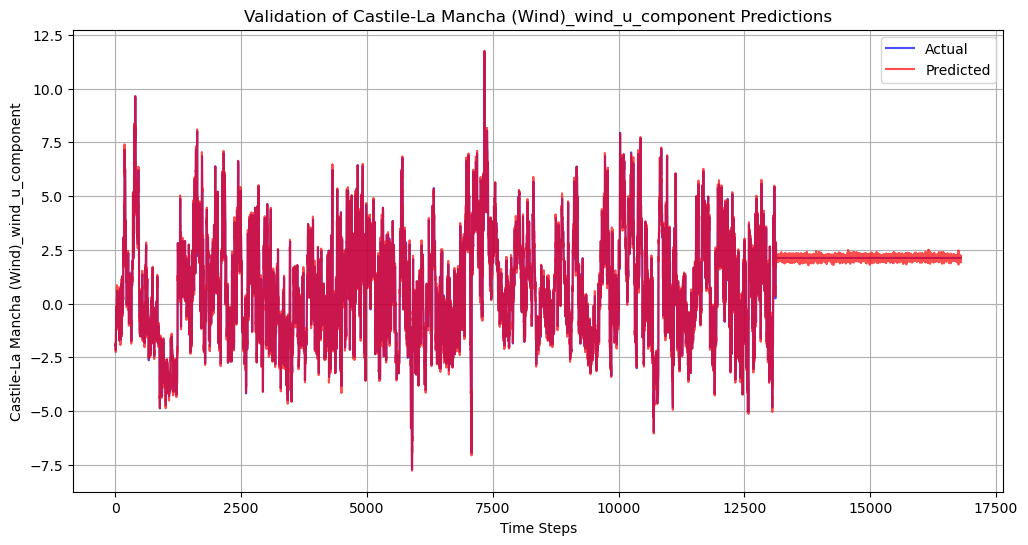

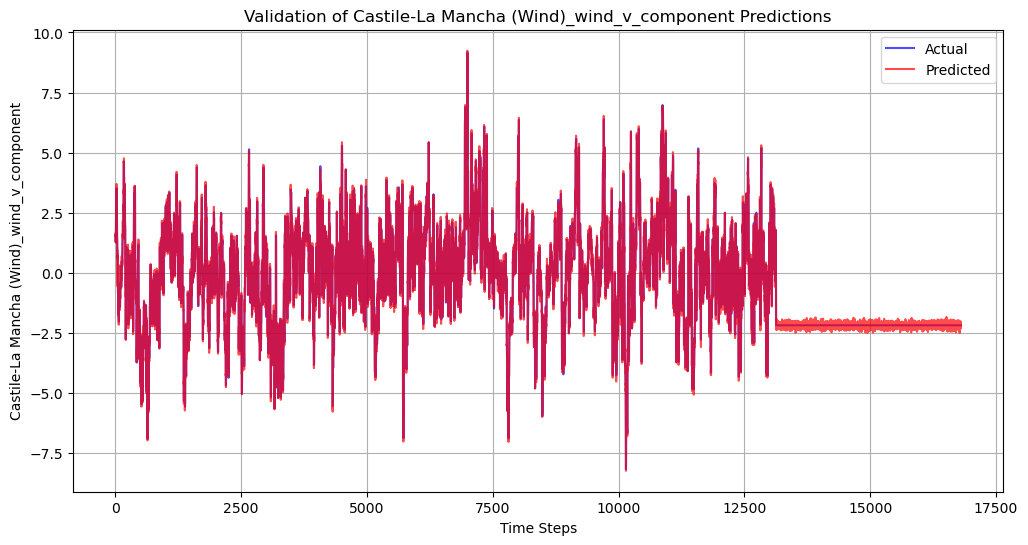

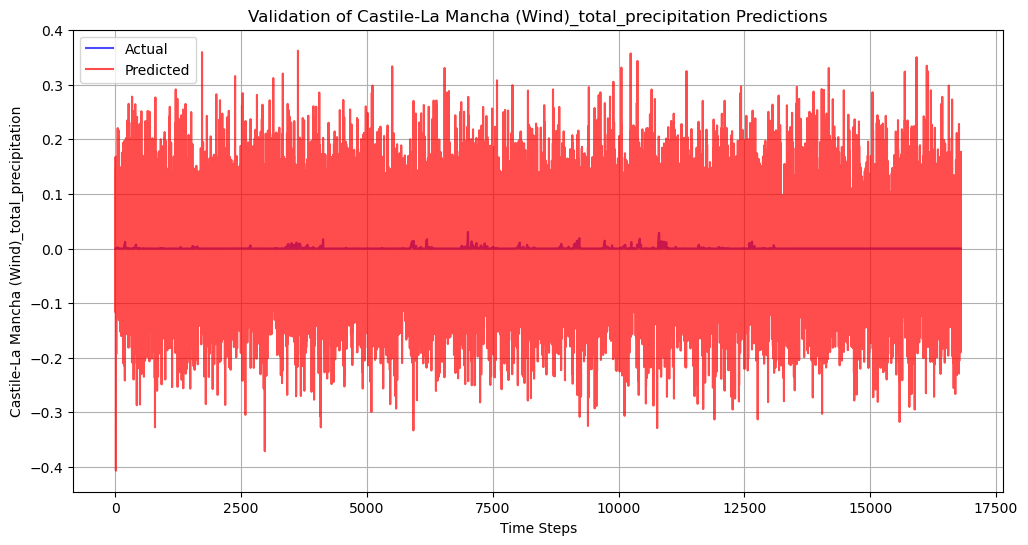

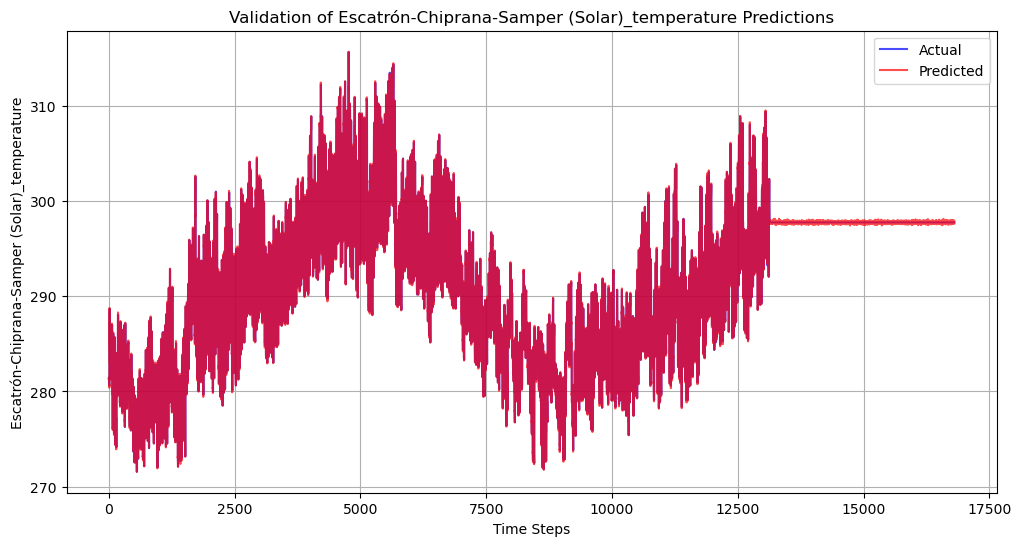

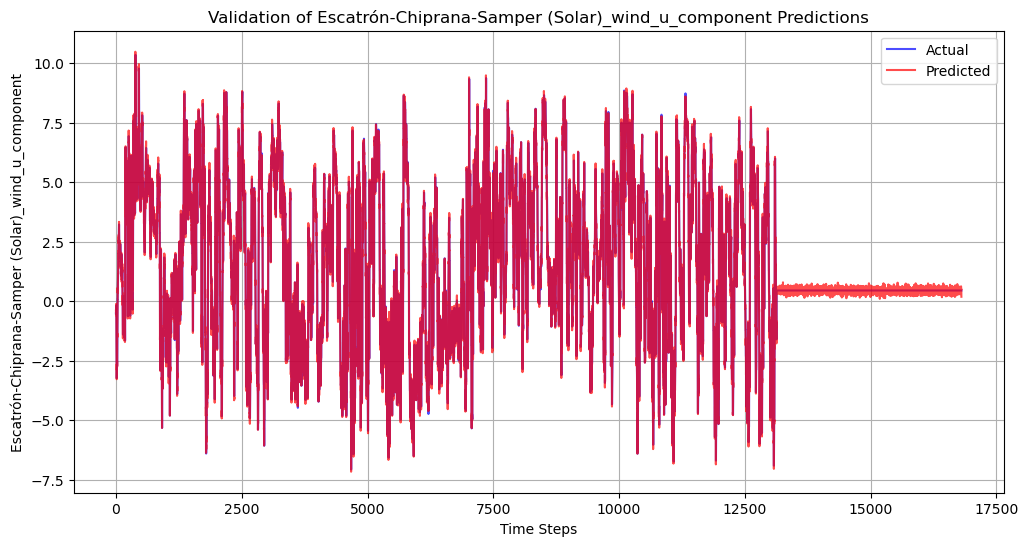

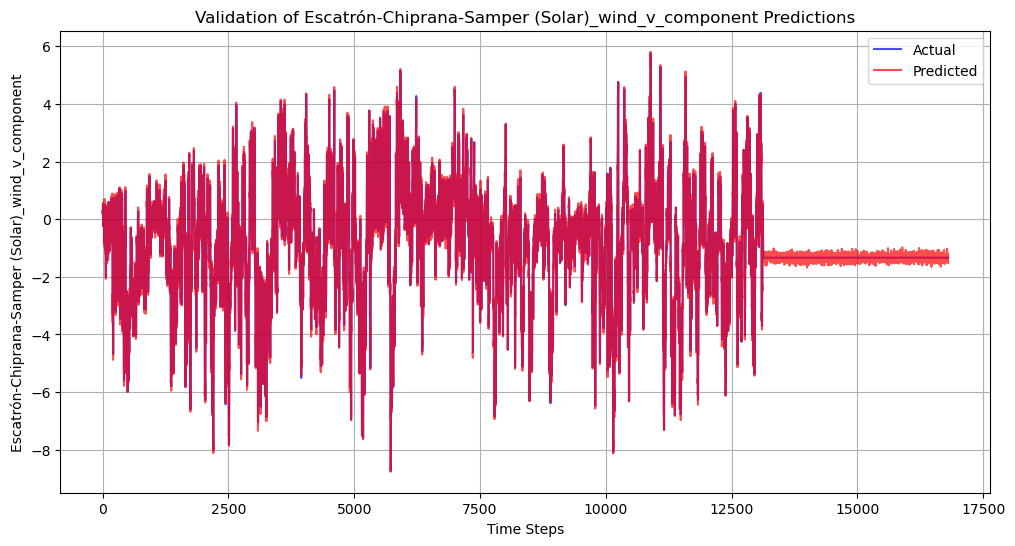

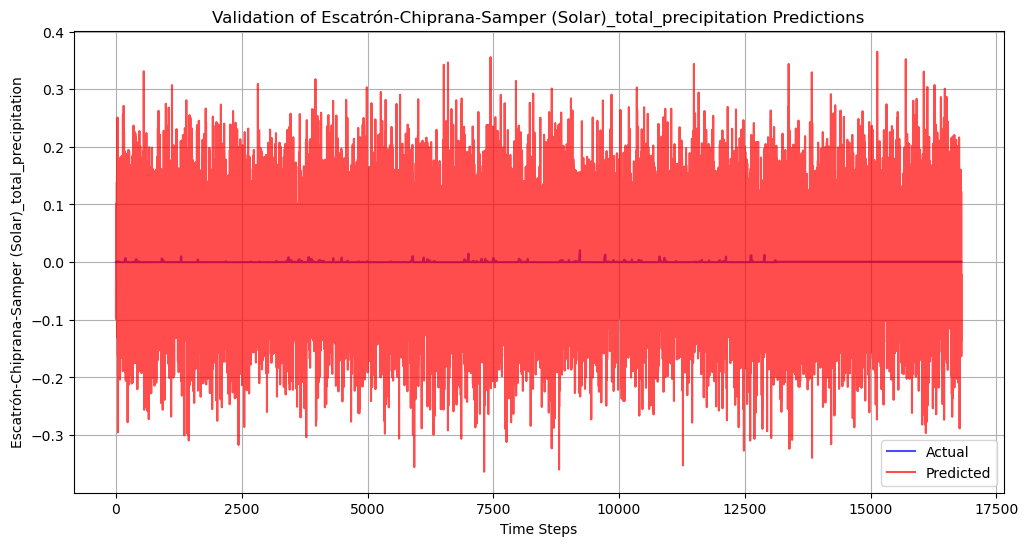

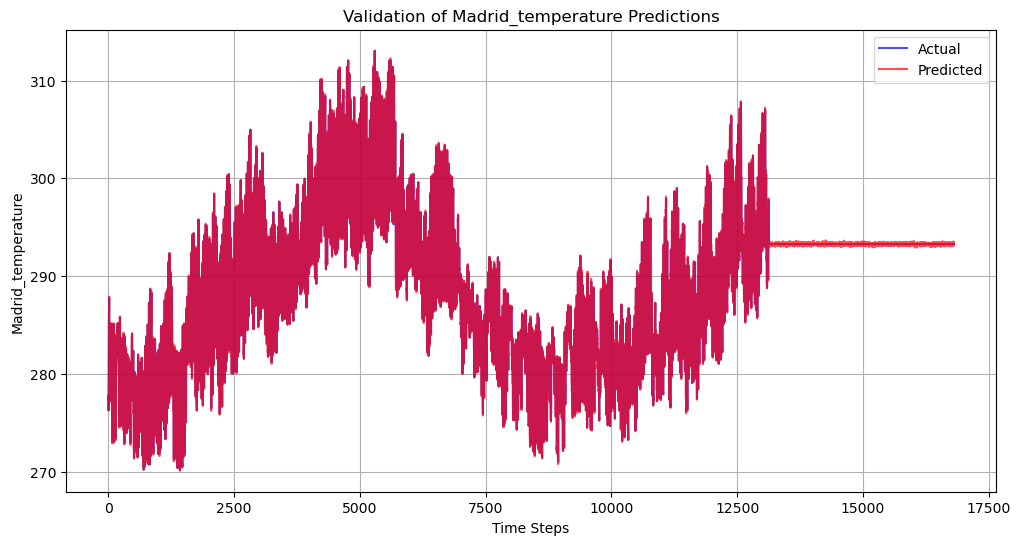

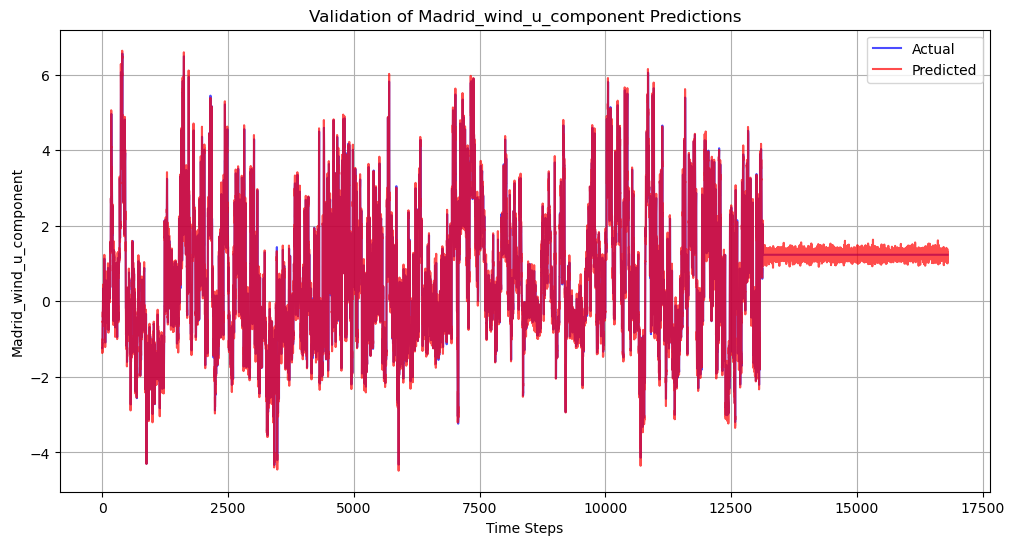

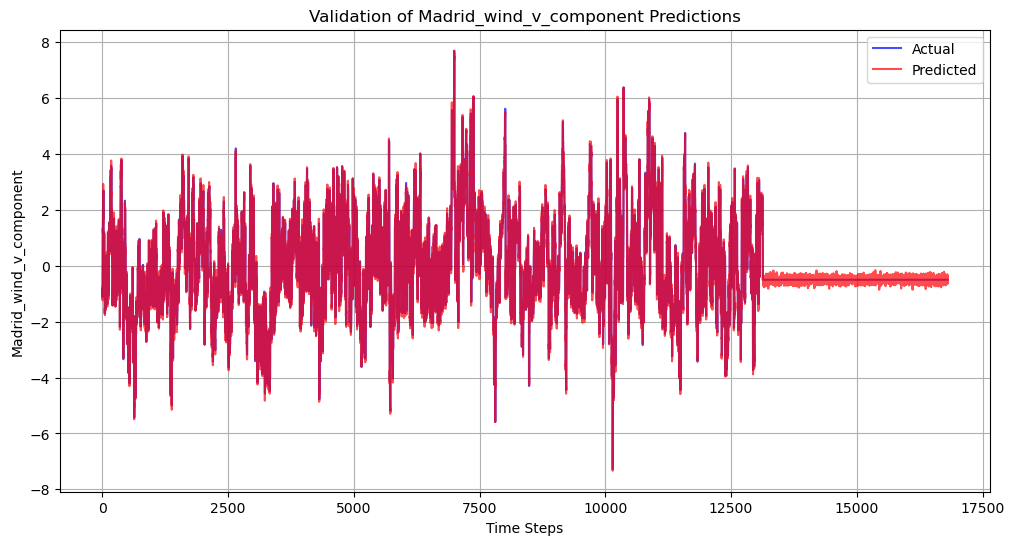

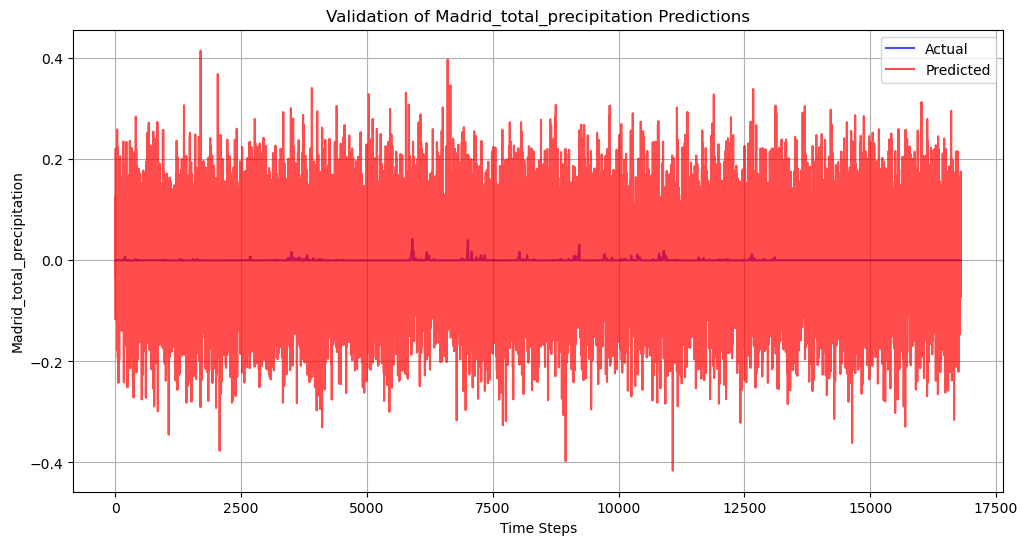

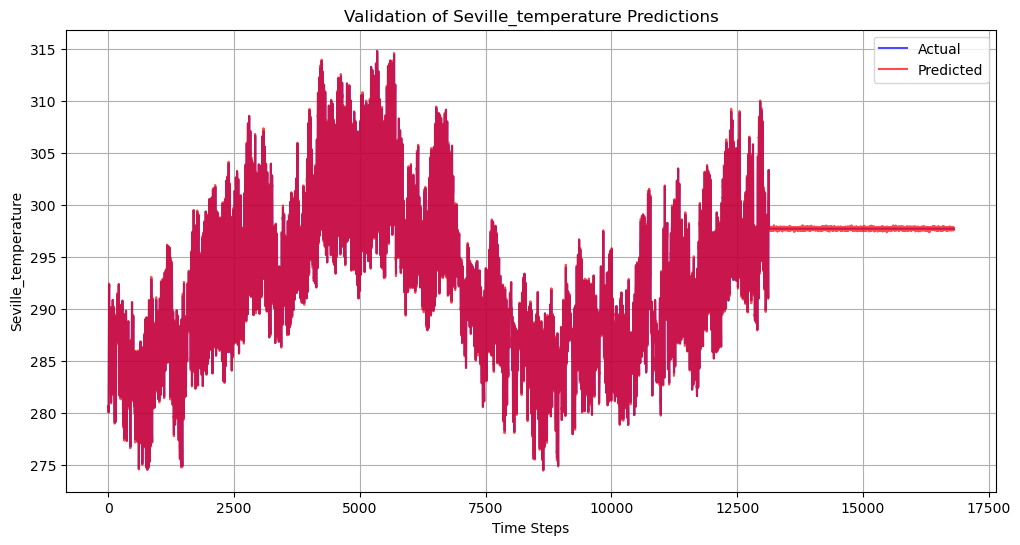

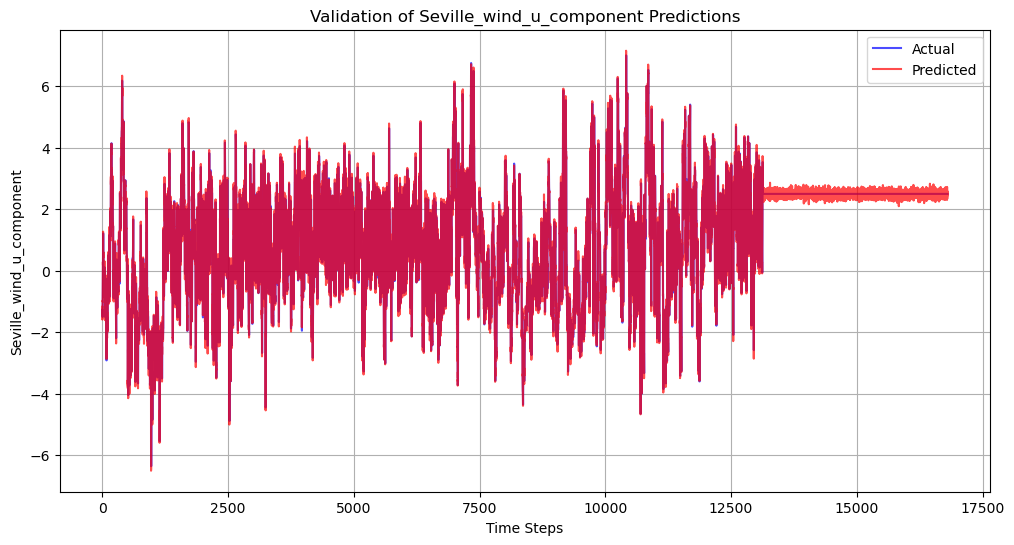

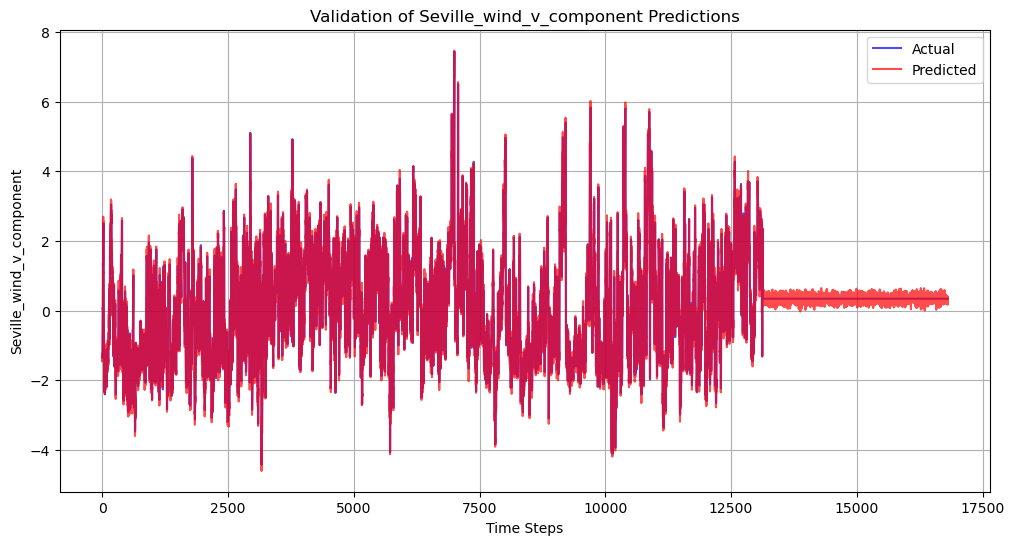

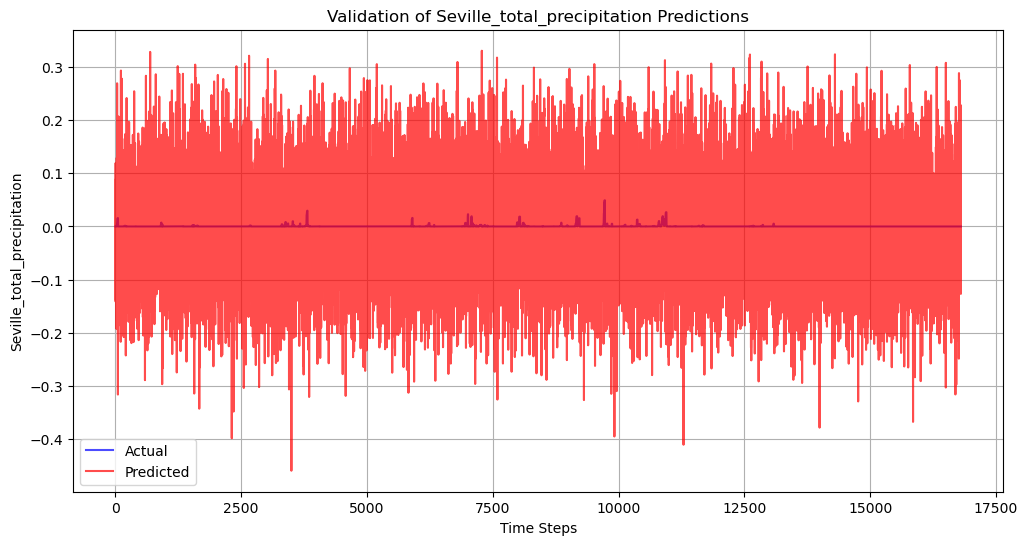

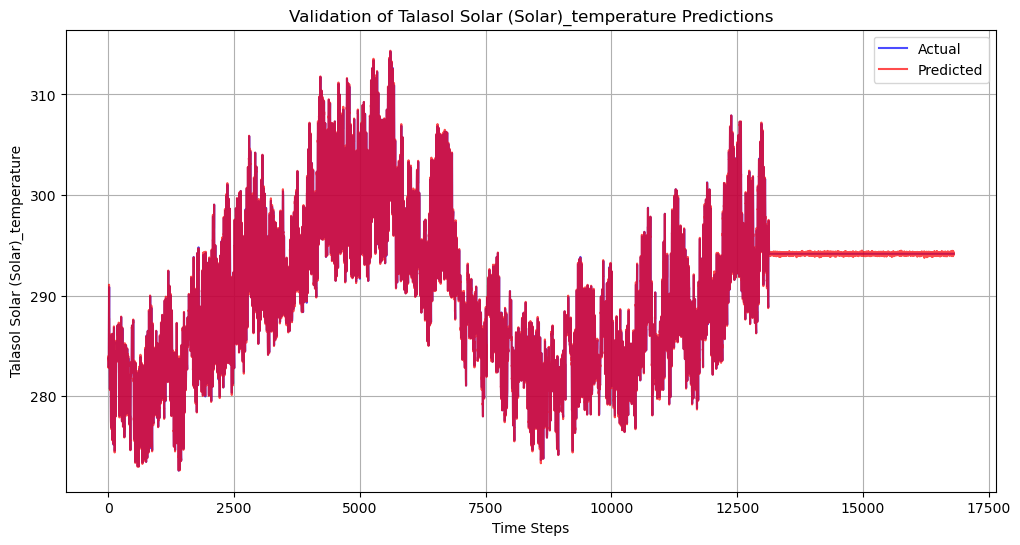

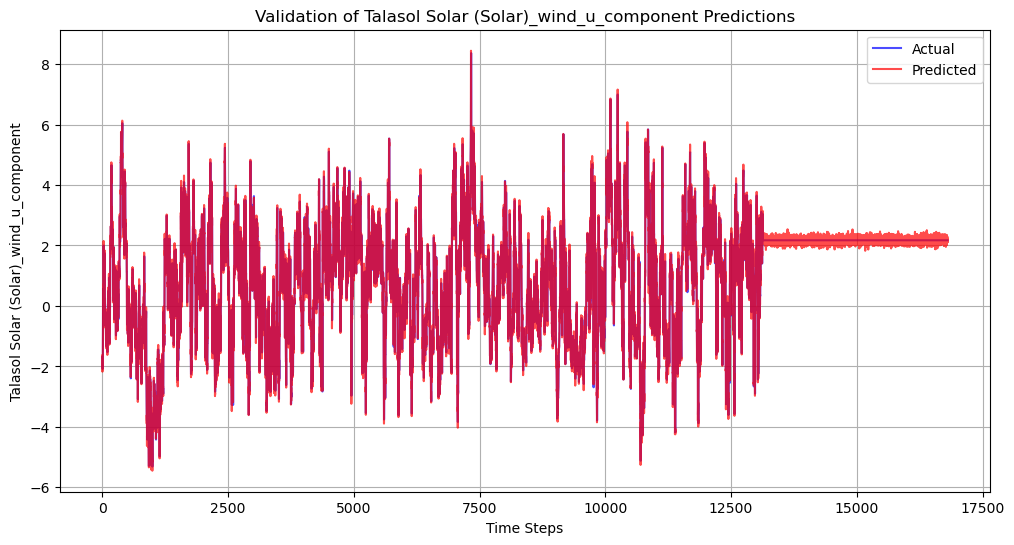

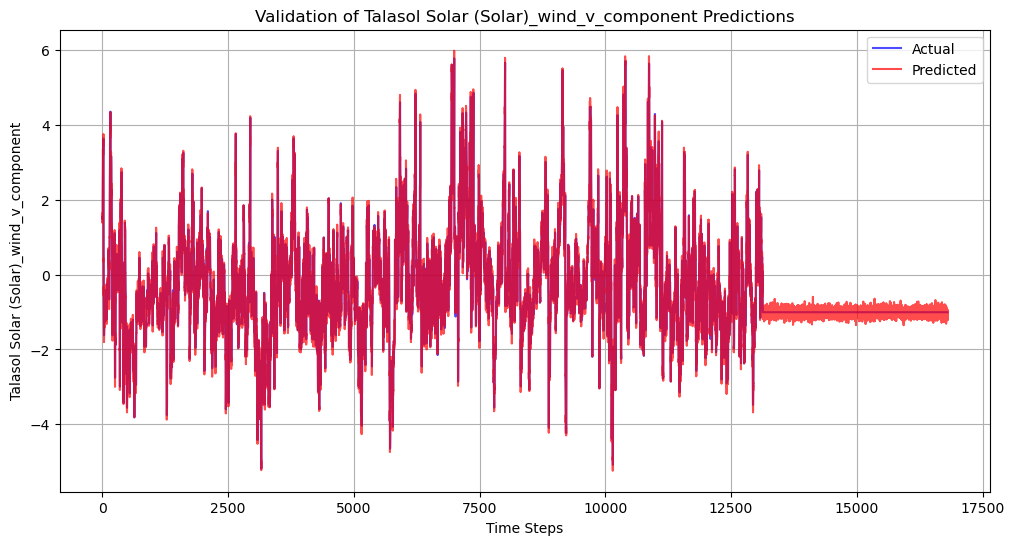

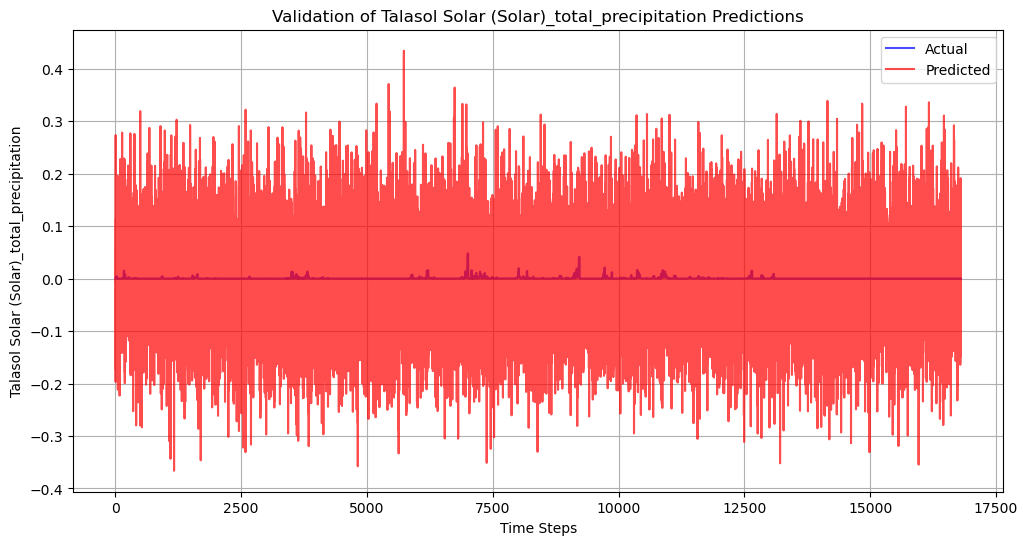

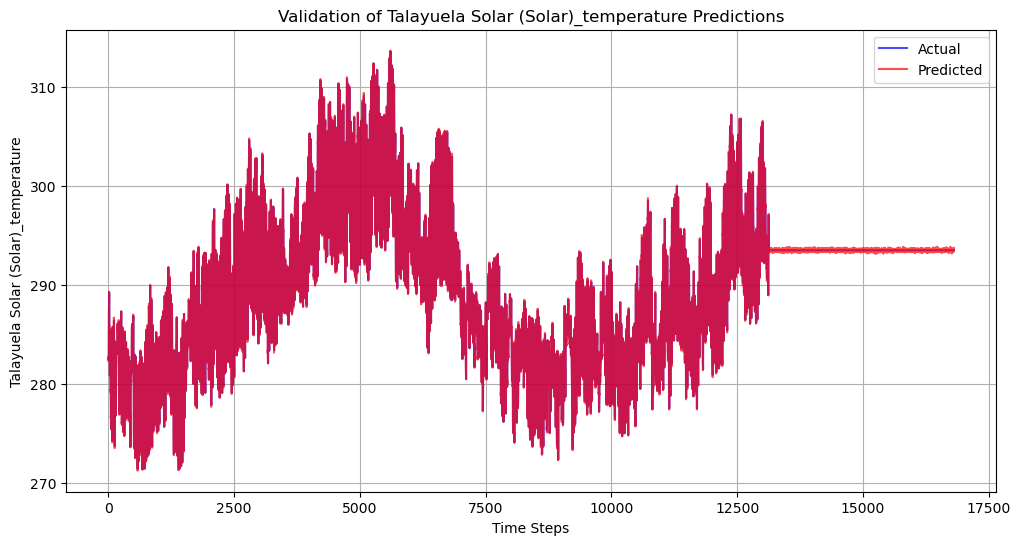

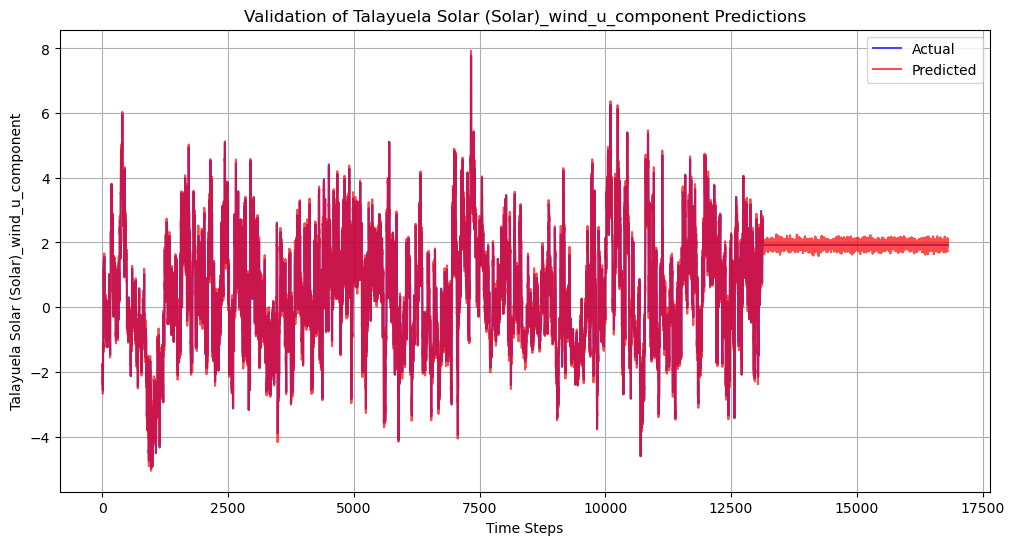

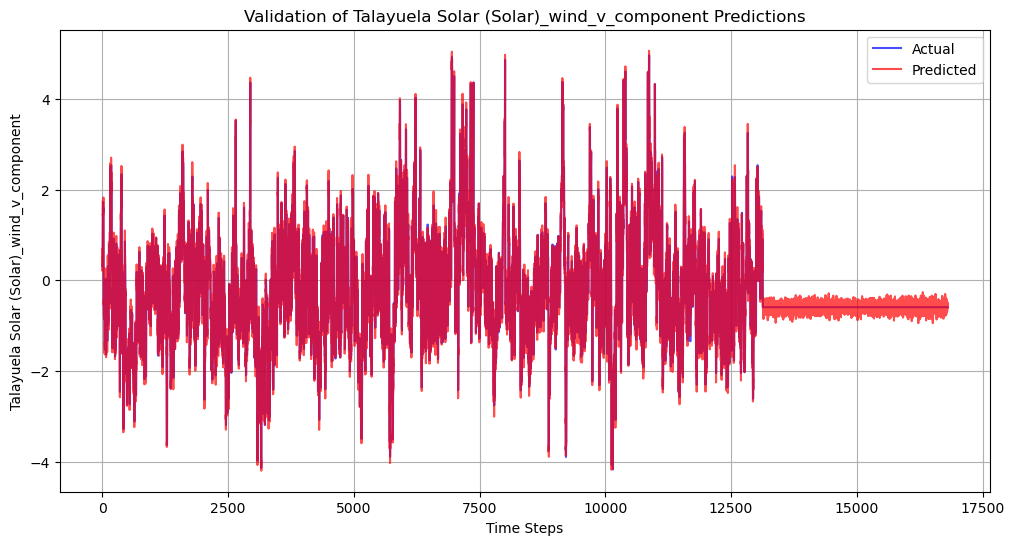

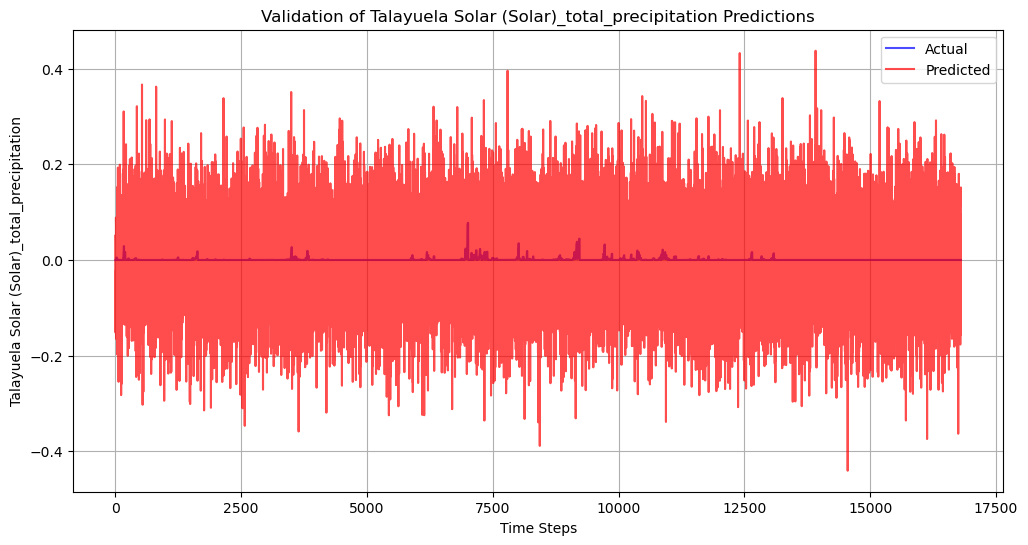

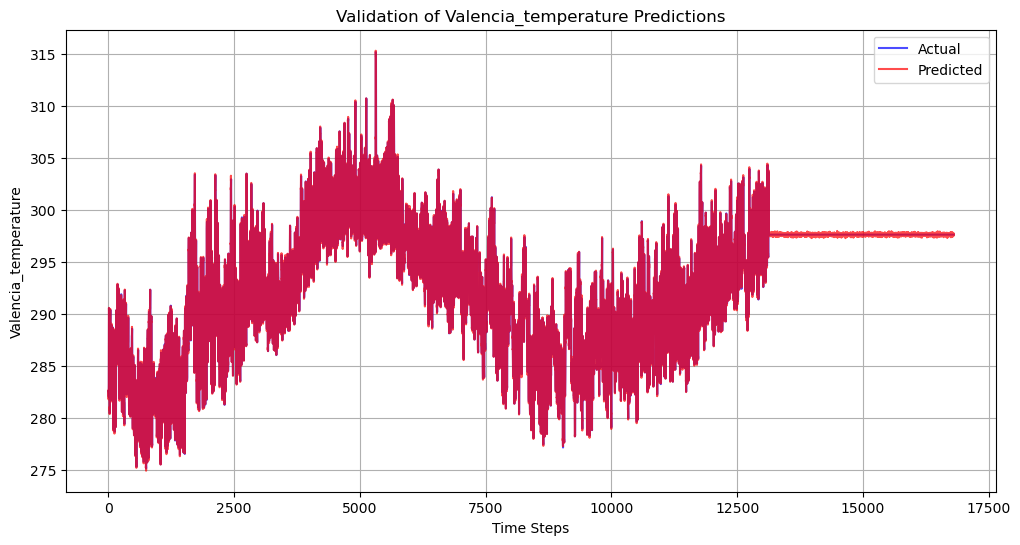

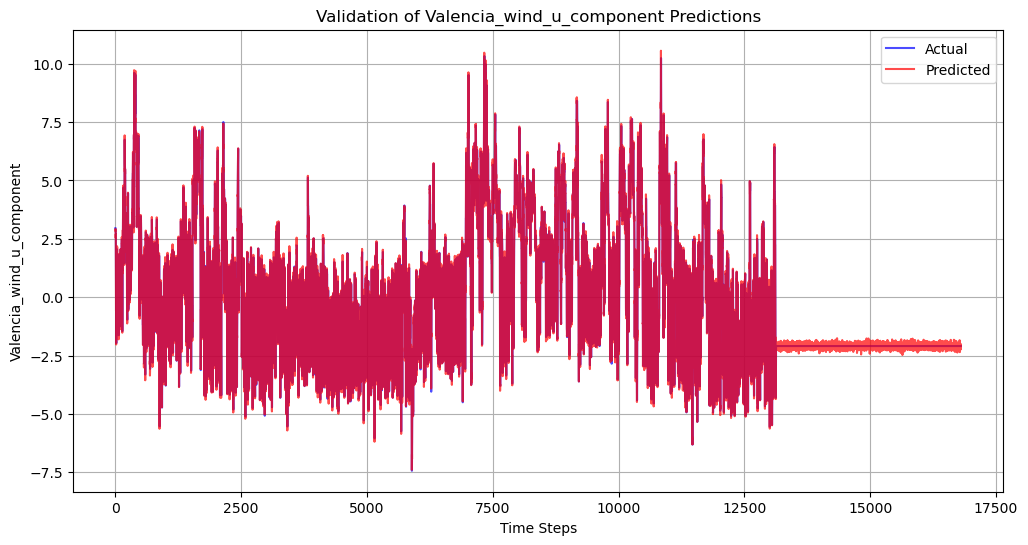

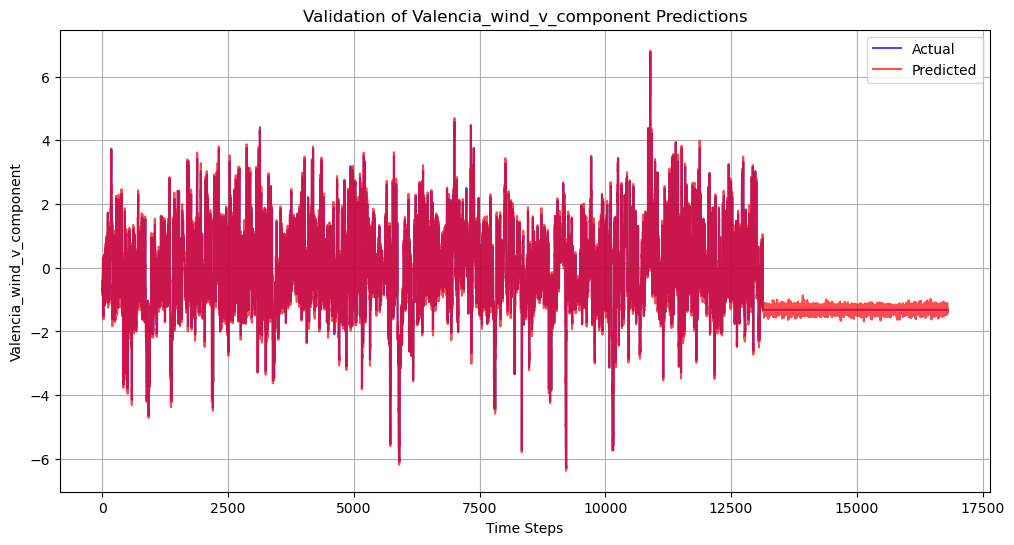

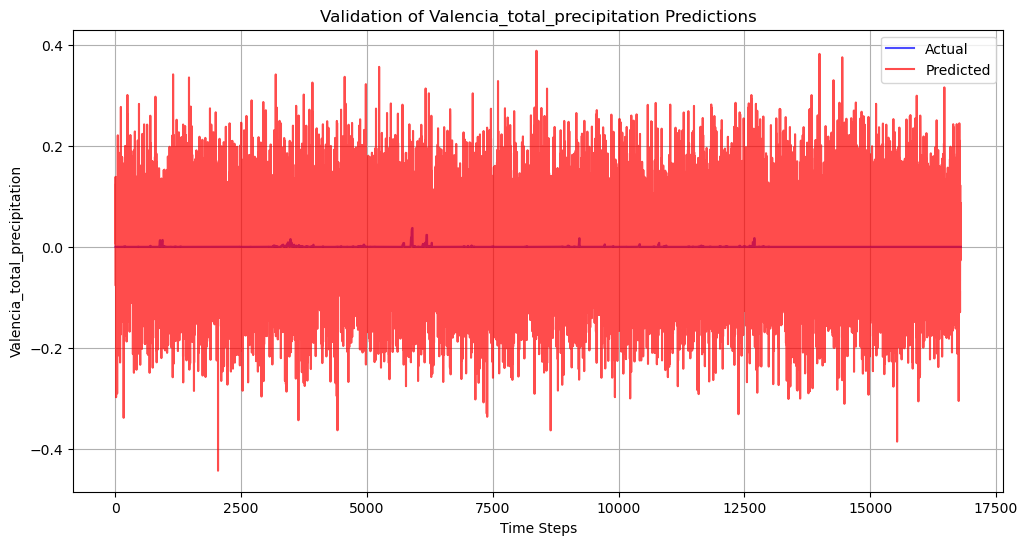

### Validation Results ###
                                                    mean_difference  \
Andalusia (Wind)_temperature                               0.001488   
Andalusia (Wind)_wind_u_component                         -0.001199   
Andalusia (Wind)_wind_v_component                         -0.000236   
Andalusia (Wind)_total_precipitation                       0.000561   
Aragon (Wind)_temperature                                  0.001974   
Aragon (Wind)_wind_u_component                             0.001815   
Aragon (Wind)_wind_v_component                            -0.000507   
Aragon (Wind)_total_precipitation                         -0.000621   
Barcelona_temperature                                      0.001311   
Barcelona_wind_u_component                                -0.000040   
Barcelona_wind_v_component                                 0.002001   
Barcelona_total_precipitation                             -0.001293   
Bilbao_temperature                                

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File paths
formatted_data_path = '../formatted_data/formatted_data.csv'
formatted_data_with_predictions_path = '../formatted_data/formatted_data_withWeatherPrediction.csv'

# Load datasets
original_data = pd.read_csv(formatted_data_path)
with_predictions_data = pd.read_csv(formatted_data_with_predictions_path)

# Identify weather columns
weather_columns = [col for col in original_data.columns if '_temperature' in col or '_wind_' in col or '_precipitation' in col]

# Validate weather predictions
def validate_weather_predictions(original, predictions, noise_std):
    validation_results = {}

    for col in weather_columns:
        actual = original[col].iloc[:-1].values  # Exclude the last row because predictions were shifted up
        predicted = predictions[f"{col}_Predicted"].iloc[:-1].values  # Align indices

        # Calculate differences
        differences = predicted - actual

        # Check if differences are within the Gaussian noise limit
        within_limit = np.abs(differences) <= (3 * noise_std)  # 3 standard deviations

        validation_results[col] = {
            'mean_difference': np.mean(differences),
            'std_difference': np.std(differences),
            'percentage_within_limit': np.mean(within_limit) * 100
        }

        # Plot for visual inspection
        plt.figure(figsize=(12, 6))
        plt.plot(actual, label="Actual", color="blue", alpha=0.7)
        plt.plot(predicted, label="Predicted", color="red", alpha=0.7)
        plt.title(f"Validation of {col} Predictions")
        plt.xlabel("Time Steps")
        plt.ylabel(col)
        plt.legend()
        plt.grid(True)
        plt.show()

    return pd.DataFrame(validation_results).T

# Validate and display results
noise_std = 0.1
validation_results = validate_weather_predictions(original_data, with_predictions_data, noise_std)

# Display validation results
print("### Validation Results ###")
print(validation_results)

# Save validation results to a CSV for reference
validation_results.to_csv('../formatted_data/weather_prediction_validation_results.csv', index=True)
print("Validation results saved to '../formatted_data/weather_prediction_validation_results.csv'")


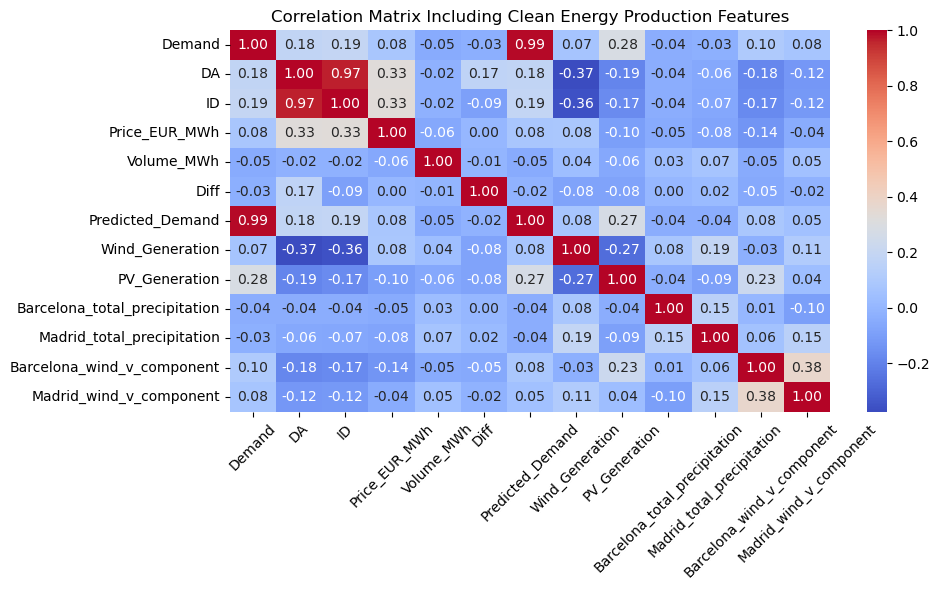

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned dataset
file_path = "../formatted_data/formatted_data.csv"
data = pd.read_csv(file_path)

# Select relevant numeric columns for correlation
non_weather_and_production_columns = [
    'Demand', 'DA', 'ID', 'Price_EUR_MWh', 'Volume_MWh', 'Diff', 'Predicted_Demand',
    'Wind_Generation', 'PV_Generation', 'Barcelona_total_precipitation', 'Madrid_total_precipitation', 'Barcelona_wind_v_component', 'Madrid_wind_v_component'  # Production features
]

# Drop NaN values for selected columns
numeric_data = data[non_weather_and_production_columns].dropna()

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix Including Clean Energy Production Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
